<a href="https://colab.research.google.com/github/Legend101Zz/ml-from-scratch/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import math

class Value:
   def __init__(self,data , _children = (), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label

   def __repr__(self):
    return f"Value(data = {self.data})"

   def __add__(self,other):
     other  = other if isinstance(other,Value) else Value(other)
     out = Value(self.data + other.data , (self, other) , '+')

     def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
     out._backward = _backward

     return out

   def __sub__(self,other):
     return self + (-other)

   def __radd__(self,other):
    return self + other

   def __rsub__(self,other):
    return self - other

   def __mul__(self,other):
     other  = other if isinstance(other,Value) else Value(other)
     out = Value(self.data * other.data, (self, other), '*')
     def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
     out._backward = _backward
     return out

   def __rmul__(self,other):
      return self * other

   def __truediv__(self,other): # self /other
    return self * other**-1

   def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data ** (other - 1))* out.grad
    out._backward = _backward
    return out

   def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1) /(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

   def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

   def backward(self):
     topo = []
     visited = set()

     def build_topo(v):
      if v not in visited :
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

     build_topo(self)
     self.grad = 1.0
     for node in reversed(topo):
      node._backward()



In [29]:
a = Value(2.0 , label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;
e.label = 'e'
d= e  + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f
L.label = 'L'
L

Value(data = -8.0)

In [30]:
from graphviz import Digraph
# import inspect

def trace(root):
  # print(inspect.stack())
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    # print(inspect.stack())
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

In [31]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes , edges  = trace(root)
  for n in nodes:
    uid = str(id(n))

    # for any value in graph , create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data % .4f | grad %.4f }" % (n.label, n.data, n.grad ), shape = 'record')

    if n._op:
      # if this value is a result of some operation , create an op node ofor it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

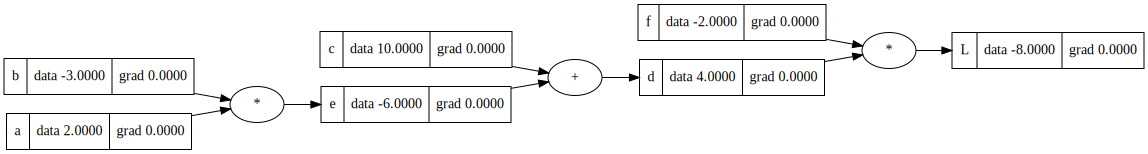

In [32]:
draw_dot(L)

In [57]:
# a simple NN
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(2.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'


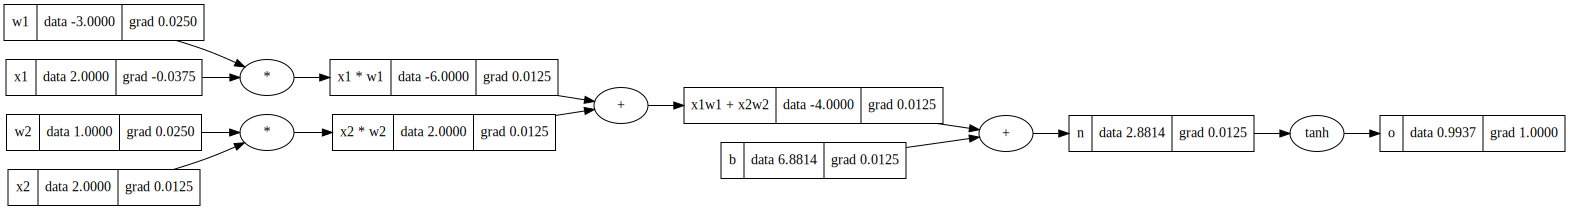

In [58]:
o.backward()
draw_dot(o)

In [55]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()
# o.grad = 1.0

# topo = []
# visited = set()

# def build_topo(v):
#   if v not in visited :
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)

# build_topo(o)

# for node in reversed(topo):
#   node._backward()


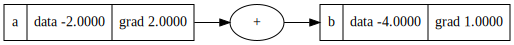

In [39]:
# bug we have in current impl

a = Value(-2.0, label ='a')
b = a + a ; b.label= 'b'
b.backward()
draw_dot(b)
# grad should be 2 but it's 1

In [63]:
a = Value(2.0)
1 + a

Value(data = 3.0)

In [47]:
a * 2
2* a

Value(data = 4.0)

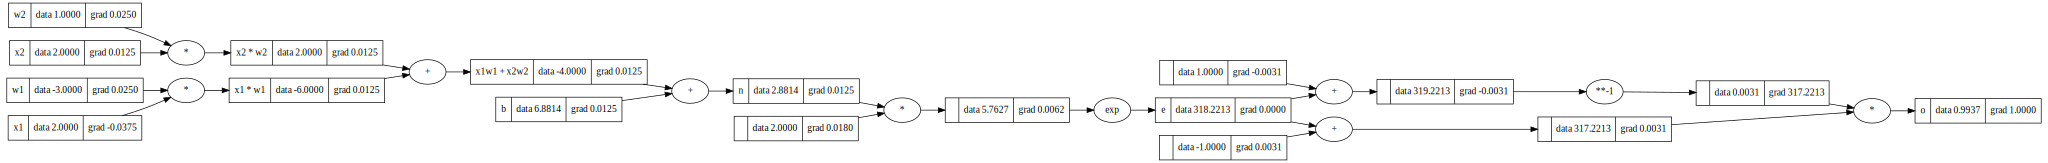

In [51]:
# a simple NN
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(2.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'

# --- now use exp formula of tanh

e = (2*n).exp() ;  e.label= 'e'
o = (e - 1) / (e+ 1);  o.label= 'o'
o.backward()
draw_dot(o)

In [121]:
import random

class Neuron :

  def __init__(self, nin):
    self.w = [ Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act : Value = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [ n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
   def __init__(self, nin, nouts):
    sz = [nin] + nouts
    print(sz)
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

   def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

   def parameters(self):
    return [ params for layer in self.layers for params in layer.parameters()]


In [122]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

[3, 4, 4, 1]


Value(data = -0.8326548804580977)

In [123]:
n.parameters()
len(n.parameters())

41

In [124]:
# small dataset for training our MLP

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0,-1.0,-1.0,1.0] # desired targets


In [125]:
# Gradient Descent
for k in range(25):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k , loss.data,)

0 7.171264432837402
1 5.30762163679935
2 1.5886709236040288
3 0.6449975203762417
4 0.33552403135360775
5 0.22340787306870463
6 0.1661862744851155
7 0.1310769095384871
8 0.10756180257290526
9 0.09081826077824984
10 0.0783449267684502
11 0.06872433150241311
12 0.06109717196935637
13 0.05491407299976789
14 0.049808375345680084
15 0.04552652767719992
16 0.04188789462223057
17 0.038760483688827396
18 0.036045716818791484
19 0.033668558489702335
20 0.031570931692030985
21 0.029707215924238577
22 0.02804110025096014
23 0.026543339984875652
24 0.02519012916221361


In [126]:
ypred

[Value(data = 0.9201137941152095),
 Value(data = -0.9664209684887222),
 Value(data = -0.9094012688372719),
 Value(data = 0.9026725022102448)]

In [127]:
n.parameters()

[Value(data = 0.031266326431049714),
 Value(data = -0.4688431014918835),
 Value(data = -0.3448807485984109),
 Value(data = -0.038023567884100856),
 Value(data = -0.49674327308906885),
 Value(data = 0.6069393959239177),
 Value(data = -0.7520336333436672),
 Value(data = -0.5335336199986096),
 Value(data = 0.46816835259051826),
 Value(data = 0.8225476069140337),
 Value(data = -0.09106655125557467),
 Value(data = -0.6955368199123774),
 Value(data = 0.6149330820011372),
 Value(data = -0.23696774009930643),
 Value(data = 1.140906261676247),
 Value(data = -0.6101906041717468),
 Value(data = 0.8948250995398885),
 Value(data = -0.5690217178891196),
 Value(data = 0.2921504488137155),
 Value(data = 0.5885490302643627),
 Value(data = 0.3344824384290427),
 Value(data = -0.6356420317504928),
 Value(data = 0.02387003714845177),
 Value(data = 0.32588005428647693),
 Value(data = 0.8795241248862986),
 Value(data = 0.31877117548116685),
 Value(data = -0.41846963933974973),
 Value(data = -0.33158632929069

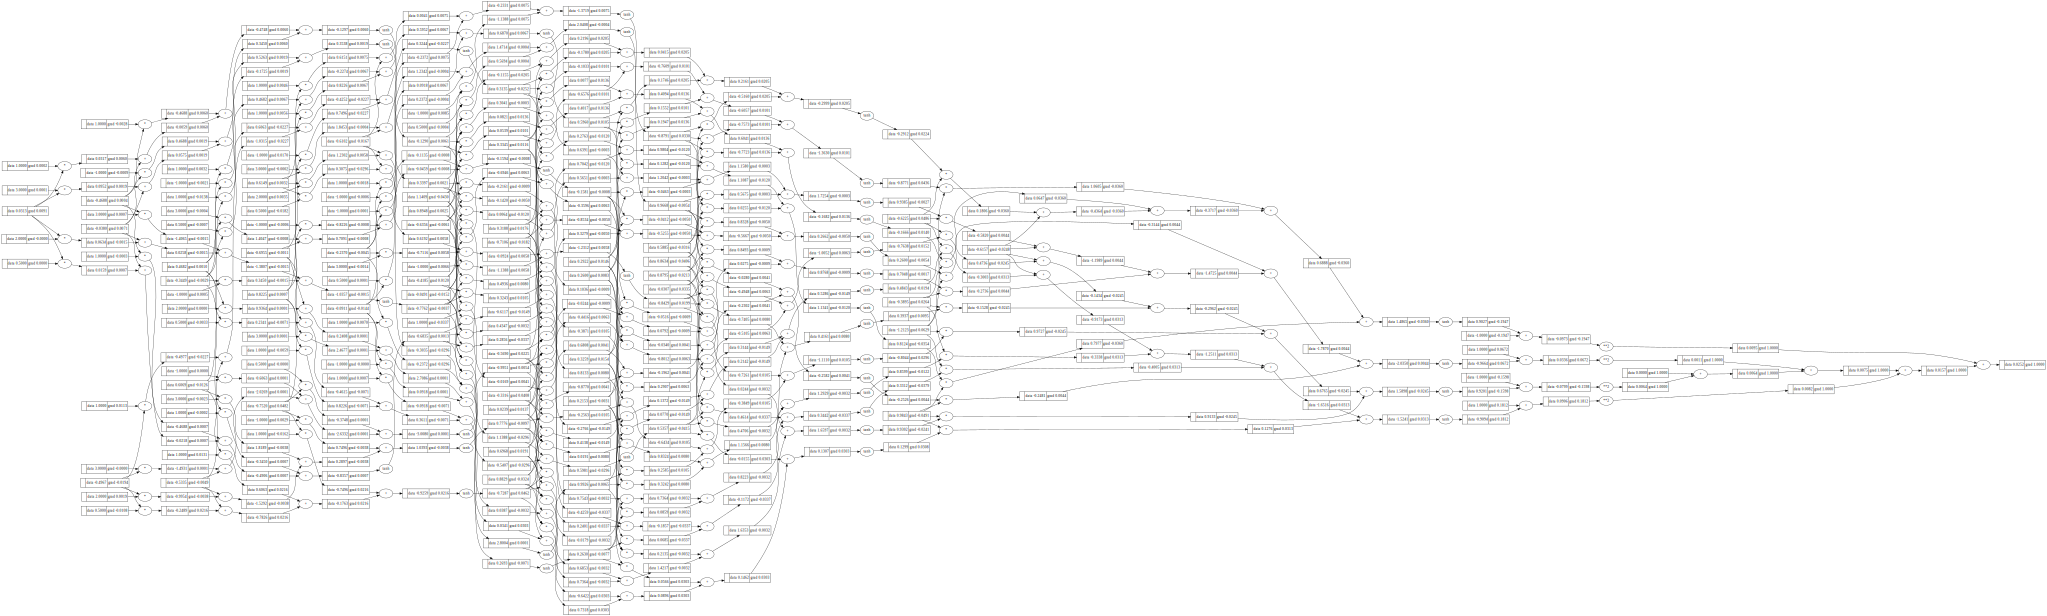

In [129]:
draw_dot(loss)